
['Power' 'Edmonton McIntyre' 'Wagner' 'Station 401' 'Edmonton Central'
 'Edmonton East' 'Edmonton Northwest' 'Tomahawk'
 'Fort Saskatchewan-Downtown (old)' 'Genesee' 'Scotford' 'Violet Grove'
 'Ross Creek' 'Fort Saskatchewan-92 St and 96 Ave' 'Meadows' 'St. Albert'
 'Edmonton South' 'Scotford (Temporary)' 'Elk Island' 'Range Road 220'
 'Lamont County' 'Sherwood Park' 'Ardrossan' 'Drayton Valley' 'Scotford 2'
 'Wagner2' 'Bruderheim' 'Woodcroft' 'Sherwood Park (New)' 'Gold Bar'
 'Beverly' 'Gibbons' 'Bruderheim 1' 'New Sarepta' 'Edmonton-Woodcroft'
 'Edmonton-Gold Bar' 'Edmonton-Beverly' 'Edmonton McCauley'
 'Edmonton Lendrum']
['Jun 03, 2005' 'Jun 04, 2005' 'Jun 05, 2005' ... 'Aug 06, 2023'
 'Aug 21, 2023' 'Aug 30, 2023']


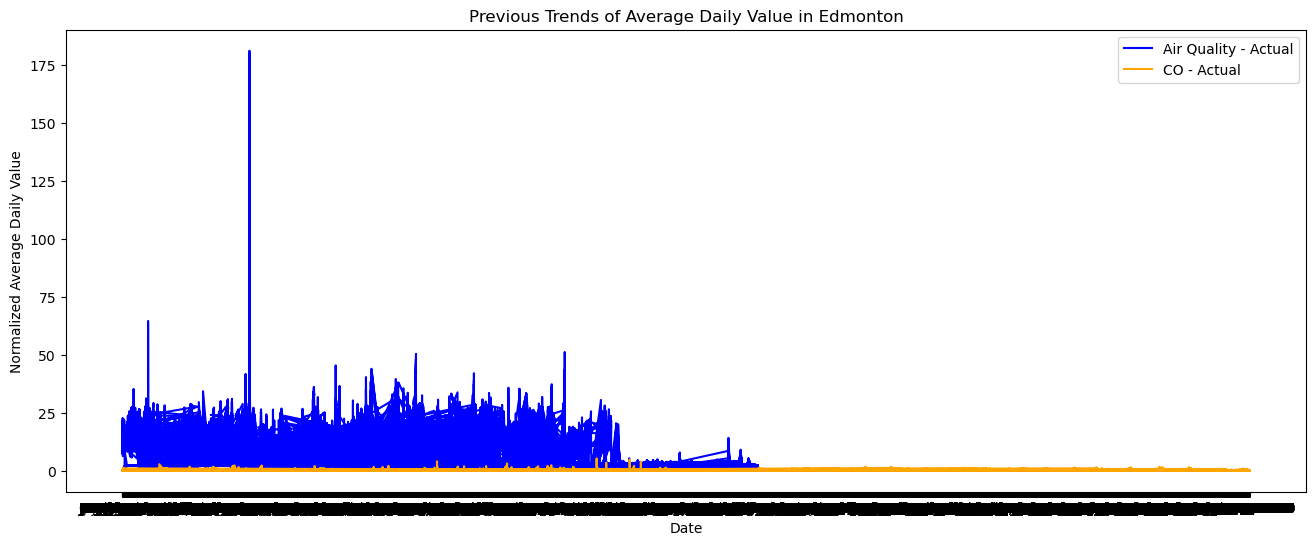



Epoch 1/20

1613/1613 [==============================] - 9s 3ms/step - loss: 3.9271e-04
Epoch 2/20
1613/1613 [==============================] - 8s 5ms/step - loss: 3.5432e-04
Epoch 3/20
1613/1613 [==============================] - 6s 3ms/step - loss: 3.4825e-04
Epoch 4/20
1613/1613 [==============================] - 6s 4ms/step - loss: 3.4729e-04
Epoch 5/20
1613/1613 [==============================] - 6s 4ms/step - loss: 3.4563e-04
Epoch 6/20
1613/1613 [==============================] - 5s 3ms/step - loss: 3.4256e-04
Epoch 7/20
1613/1613 [==============================] - 6s 3ms/step - loss: 3.4211e-04
Epoch 8/20
1613/1613 [==============================] - 6s 4ms/step - loss: 3.4204e-04
Epoch 9/20
1613/1613 [==============================] - 6s 3ms/step - loss: 3.4127e-04
Epoch 10/20
1613/1613 [==============================] - 6s 3ms/step - loss: 3.3962e-04
Epoch 11/20
1613/1613 [==============================] - 6s 4ms/step - loss: 3.3879e-04
Epoch 12/20
1613/1613 [===============

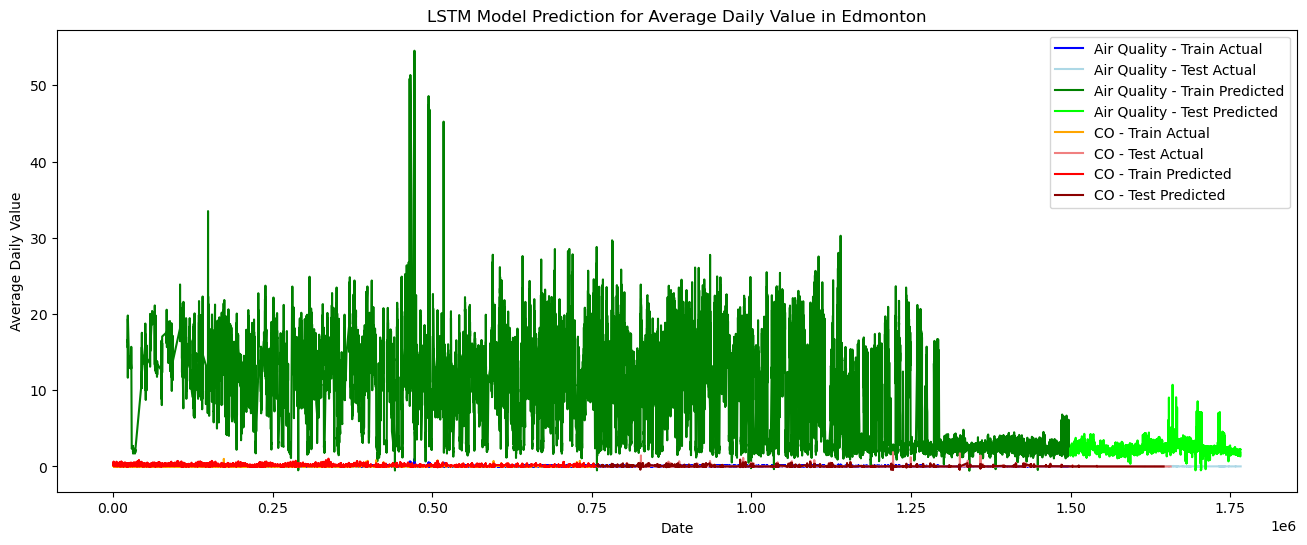

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Read the dataset
df = pd.read_csv("air.csv")

# Drop unnecessary columns
df.drop(['Row ID', 'Geo Location'], axis=1, inplace=True)

# Print unique values in the 'Monitoring Station Name' column
print(df['Monitoring Station Name'].unique())

# Print unique values in the 'Date Measured' column
print(df['Date Measured'].unique())


# Filter data for individual parameters
air_quality_df = df[df['Parameter Measured'].str.contains('Air Quality', case=False)]
co_df = df[df['Parameter Measured'].str.contains('CO', case=False)]



# Train-test split for each parameter
air_quality_train_size = int(len(air_quality_df) * 0.8)
air_quality_train, air_quality_test = air_quality_df[:air_quality_train_size], air_quality_df[air_quality_train_size:]

co_train_size = int(len(co_df) * 0.8)
co_train, co_test = co_df[:co_train_size], co_df[co_train_size:]

# Check if there is data for each parameter
if len(air_quality_train) == 0 or len(air_quality_test) == 0:
    raise ValueError("No data available for Air Quality. Please check the filtering criteria.")
if len(co_train) == 0 or len(co_test) == 0:
    raise ValueError("No data available for CO. Please check the filtering criteria.")

# Normalize 'Average Daily Value' using Min-Max scaling for each parameter
scaler_air_quality = MinMaxScaler()
air_quality_train['Average Daily Value'] = scaler_air_quality.fit_transform(air_quality_train[['Average Daily Value']])
air_quality_test['Average Daily Value'] = scaler_air_quality.transform(air_quality_test[['Average Daily Value']])

scaler_co = MinMaxScaler()
co_train['Average Daily Value'] = scaler_co.fit_transform(co_train[['Average Daily Value']])
co_test['Average Daily Value'] = scaler_co.transform(co_test[['Average Daily Value']])

# Plot previous trends for each parameter
plt.figure(figsize=(16, 6))
plt.plot(air_quality_df['Date Measured'], air_quality_df['Average Daily Value'], label='Air Quality - Actual', color='blue')
plt.plot(co_df['Date Measured'], co_df['Average Daily Value'], label='CO - Actual', color='orange')
plt.title('Previous Trends of Average Daily Value in Edmonton')
plt.xlabel('Date')
plt.ylabel('Normalized Average Daily Value')
plt.legend()
plt.show()

# Prepare data for LSTM for each parameter
def create_lstm_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, 0])
    return np.array(dataX), np.array(dataY)

time_steps = 30  # Adjust as needed

# For Air Quality parameter
air_quality_train_data = air_quality_train[['Average Daily Value']].values
air_quality_test_data = air_quality_test[['Average Daily Value']].values

air_quality_trainX, air_quality_trainY = create_lstm_dataset(air_quality_train_data, time_steps)
air_quality_testX, air_quality_testY = create_lstm_dataset(air_quality_test_data, time_steps)

# For CO parameter
co_train_data = co_train[['Average Daily Value']].values
co_test_data = co_test[['Average Daily Value']].values

co_trainX, co_trainY = create_lstm_dataset(co_train_data, time_steps)
co_testX, co_testY = create_lstm_dataset(co_test_data, time_steps)

# Reshape data for LSTM input for each parameter
air_quality_trainX = np.reshape(air_quality_trainX, (air_quality_trainX.shape[0], 1, air_quality_trainX.shape[1]))
air_quality_testX = np.reshape(air_quality_testX, (air_quality_testX.shape[0], 1, air_quality_testX.shape[1]))

co_trainX = np.reshape(co_trainX, (co_trainX.shape[0], 1, co_trainX.shape[1]))
co_testX = np.reshape(co_testX, (co_testX.shape[0], 1, co_testX.shape[1]))

# Build LSTM model for each parameter
model_air_quality = Sequential()
model_air_quality.add(LSTM(50, input_shape=(1, time_steps)))
model_air_quality.add(Dense(1))
model_air_quality.compile(optimizer='adam', loss='mean_squared_error')

model_co = Sequential()
model_co.add(LSTM(50, input_shape=(1, time_steps)))
model_co.add(Dense(1))
model_co.compile(optimizer='adam', loss='mean_squared_error')

# Train the models for each parameter
model_air_quality.fit(air_quality_trainX, air_quality_trainY, epochs=20, batch_size=32, verbose=1)
model_co.fit(co_trainX, co_trainY, epochs=20, batch_size=32, verbose=1)

# Make predictions with LSTM for each parameter
air_quality_trainPredict = model_air_quality.predict(air_quality_trainX)
air_quality_testPredict = model_air_quality.predict(air_quality_testX)

co_trainPredict = model_co.predict(co_trainX)
co_testPredict = model_co.predict(co_testX)

# Invert predictions back to original scale for each parameter
air_quality_trainPredict = scaler_air_quality.inverse_transform(air_quality_trainPredict)
air_quality_trainY = scaler_air_quality.inverse_transform([air_quality_trainY])
air_quality_testPredict = scaler_air_quality.inverse_transform(air_quality_testPredict)
air_quality_testY = scaler_air_quality.inverse_transform([air_quality_testY])

co_trainPredict = scaler_co.inverse_transform(co_trainPredict)
co_trainY = scaler_co.inverse_transform([co_trainY])
co_testPredict = scaler_co.inverse_transform(co_testPredict)
co_testY = scaler_co.inverse_transform([co_testY])

# Evaluate the models for each parameter
train_score_air_quality = np.sqrt(mean_squared_error(air_quality_trainY[0], air_quality_trainPredict[:, 0]))
print(f'Air Quality Training Root Mean Squared Error: {train_score_air_quality}')

test_score_air_quality = np.sqrt(mean_squared_error(air_quality_testY[0], air_quality_testPredict[:, 0]))
print(f'Air Quality Testing Root Mean Squared Error: {test_score_air_quality}')

train_score_co = np.sqrt(mean_squared_error(co_trainY[0], co_trainPredict[:, 0]))
print(f'CO Training Root Mean Squared Error: {train_score_co}')

test_score_co = np.sqrt(mean_squared_error(co_testY[0], co_testPredict[:, 0]))
print(f'CO Testing Root Mean Squared Error: {test_score_co}')

# Plot the results for each parameter
plt.figure(figsize=(16, 6))
plt.plot(air_quality_df.index[:len(air_quality_train)], air_quality_train['Average Daily Value'], label='Air Quality - Train Actual', color='blue')
plt.plot(air_quality_df.index[len(air_quality_train):], air_quality_test['Average Daily Value'], label='Air Quality - Test Actual', color='lightblue')
plt.plot(air_quality_df.index[time_steps-1:len(air_quality_trainPredict)+time_steps-1], air_quality_trainPredict[:, 0], label='Air Quality - Train Predicted', color='green')
plt.plot(air_quality_df.index[len(air_quality_trainPredict)+time_steps-1:len(air_quality_trainPredict)+time_steps-1+len(air_quality_testPredict)], air_quality_testPredict[:, 0], label='Air Quality - Test Predicted', color='lime')

plt.plot(co_df.index[:len(co_train)], co_train['Average Daily Value'], label='CO - Train Actual', color='orange')
plt.plot(co_df.index[len(co_train):], co_test['Average Daily Value'], label='CO - Test Actual', color='lightcoral')
plt.plot(co_df.index[time_steps-1:len(co_trainPredict)+time_steps-1], co_trainPredict[:, 0], label='CO - Train Predicted', color='red')
plt.plot(co_df.index[len(co_trainPredict)+time_steps-1:len(co_trainPredict)+time_steps-1+len(co_testPredict)], co_testPredict[:, 0], label='CO - Test Predicted', color='darkred')

plt.title('LSTM Model Prediction for Average Daily Value in Edmonton')
plt.xlabel('Date')
plt.ylabel('Average Daily Value')
plt.legend()
plt.show()


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to build an LSTM model
def build_lstm_model(input_shape=(1, 30), units=50):
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to train an LSTM model
def train_lstm_model(model, trainX, trainY, epochs=20, batch_size=32, verbose=1):
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return history

# Function to make predictions with an LSTM model
def make_lstm_predictions(model, trainX, testX):
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    return trainPredict, testPredict

# Function to evaluate an LSTM model
def evaluate_lstm_model(true_values, predicted_values):
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    return rmse

In [4]:
# Filter data for individual parameters
pm25_df = df[df['Parameter Measured'].str.contains('PM2.5 Mass', case=False)]
humidity_df = df[df['Parameter Measured'].str.contains('Relative Humidity', case=False)]
wind_direction_df = df[df['Parameter Measured'].str.contains('Std. Dev. of Wind Direction', case=False)]
wind_speed_df = df[df['Parameter Measured'].str.contains('Std. Dev. of Wind Speed', case=False)]
temperature_df = df[df['Parameter Measured'].str.contains('Outdoor Air Temperature', case=False)]

# Train-test split for each parameter
pm25_train_size = int(len(pm25_df) * 0.8)
pm25_train, pm25_test = pm25_df[:pm25_train_size], pm25_df[pm25_train_size:]

humidity_train_size = int(len(humidity_df) * 0.8)
humidity_train, humidity_test = humidity_df[:humidity_train_size], humidity_df[humidity_train_size:]

wind_direction_train_size = int(len(wind_direction_df) * 0.8)
wind_direction_train, wind_direction_test = wind_direction_df[:wind_direction_train_size], wind_direction_df[wind_direction_train_size:]

wind_speed_train_size = int(len(wind_speed_df) * 0.8)
wind_speed_train, wind_speed_test = wind_speed_df[:wind_speed_train_size], wind_speed_df[wind_speed_train_size:]

temperature_train_size = int(len(temperature_df) * 0.8)
temperature_train, temperature_test = temperature_df[:temperature_train_size], temperature_df[temperature_train_size:]

# Normalize 'Average Daily Value' using Min-Max scaling for each parameter
scaler_pm25 = MinMaxScaler()
pm25_train['Average Daily Value'] = scaler_pm25.fit_transform(pm25_train[['Average Daily Value']])
pm25_test['Average Daily Value'] = scaler_pm25.transform(pm25_test[['Average Daily Value']])

scaler_humidity = MinMaxScaler()
humidity_train['Average Daily Value'] = scaler_humidity.fit_transform(humidity_train[['Average Daily Value']])
humidity_test['Average Daily Value'] = scaler_humidity.transform(humidity_test[['Average Daily Value']])

scaler_wind_direction = MinMaxScaler()
wind_direction_train['Average Daily Value'] = scaler_wind_direction.fit_transform(wind_direction_train[['Average Daily Value']])
wind_direction_test['Average Daily Value'] = scaler_wind_direction.transform(wind_direction_test[['Average Daily Value']])

scaler_wind_speed = MinMaxScaler()
wind_speed_train['Average Daily Value'] = scaler_wind_speed.fit_transform(wind_speed_train[['Average Daily Value']])
wind_speed_test['Average Daily Value'] = scaler_wind_speed.transform(wind_speed_test[['Average Daily Value']])

scaler_temperature = MinMaxScaler()
temperature_train['Average Daily Value'] = scaler_temperature.fit_transform(temperature_train[['Average Daily Value']])
temperature_test['Average Daily Value'] = scaler_temperature.transform(temperature_test[['Average Daily Value']])

In [5]:
# Create LSTM datasets for each parameter
pm25_train_data = pm25_train[['Average Daily Value']].values
pm25_test_data = pm25_test[['Average Daily Value']].values

humidity_train_data = humidity_train[['Average Daily Value']].values
humidity_test_data = humidity_test[['Average Daily Value']].values

wind_direction_train_data = wind_direction_train[['Average Daily Value']].values
wind_direction_test_data = wind_direction_test[['Average Daily Value']].values

wind_speed_train_data = wind_speed_train[['Average Daily Value']].values
wind_speed_test_data = wind_speed_test[['Average Daily Value']].values

temperature_train_data = temperature_train[['Average Daily Value']].values
temperature_test_data = temperature_test[['Average Daily Value']].values

# Create LSTM datasets for each parameter
time_steps = 30  # Adjust as needed
pm25_trainX, pm25_trainY = create_lstm_dataset(pm25_train_data, time_steps)
pm25_testX, pm25_testY = create_lstm_dataset(pm25_test_data, time_steps)

humidity_trainX, humidity_trainY = create_lstm_dataset(humidity_train_data, time_steps)
humidity_testX, humidity_testY = create_lstm_dataset(humidity_test_data, time_steps)

wind_direction_trainX, wind_direction_trainY = create_lstm_dataset(wind_direction_train_data, time_steps)
wind_direction_testX, wind_direction_testY = create_lstm_dataset(wind_direction_test_data, time_steps)

wind_speed_trainX, wind_speed_trainY = create_lstm_dataset(wind_speed_train_data, time_steps)
wind_speed_testX, wind_speed_testY = create_lstm_dataset(wind_speed_test_data, time_steps)

temperature_trainX, temperature_trainY = create_lstm_dataset(temperature_train_data, time_steps)
temperature_testX, temperature_testY = create_lstm_dataset(temperature_test_data, time_steps)

# Reshape data for LSTM input
pm25_trainX = np.reshape(pm25_trainX, (pm25_trainX.shape[0], 1, pm25_trainX.shape[1]))
pm25_testX = np.reshape(pm25_testX, (pm25_testX.shape[0], 1, pm25_testX.shape[1]))

humidity_trainX = np.reshape(humidity_trainX, (humidity_trainX.shape[0], 1, humidity_trainX.shape[1]))
humidity_testX = np.reshape(humidity_testX, (humidity_testX.shape[0], 1, humidity_testX.shape[1]))

wind_direction_trainX = np.reshape(wind_direction_trainX, (wind_direction_trainX.shape[0], 1, wind_direction_trainX.shape[1]))
wind_direction_testX = np.reshape(wind_direction_testX, (wind_direction_testX.shape[0], 1, wind_direction_testX.shape[1]))

wind_speed_trainX = np.reshape(wind_speed_trainX, (wind_speed_trainX.shape[0], 1, wind_speed_trainX.shape[1]))
wind_speed_testX = np.reshape(wind_speed_testX, (wind_speed_testX.shape[0], 1, wind_speed_testX.shape[1]))

temperature_trainX = np.reshape(temperature_trainX, (temperature_trainX.shape[0], 1, temperature_trainX.shape[1]))
temperature_testX = np.reshape(temperature_testX, (temperature_testX.shape[0], 1, temperature_testX.shape[1]))

# Build LSTM models for each parameter
pm25_model = build_lstm_model()
humidity_model = build_lstm_model()
wind_direction_model = build_lstm_model()
wind_speed_model = build_lstm_model()
temperature_model = build_lstm_model()

## Train LSTM models for each parameter
pm25_history = train_lstm_model(pm25_model, pm25_trainX, pm25_trainY, epochs=20)
humidity_history = train_lstm_model(humidity_model, humidity_trainX, humidity_trainY, epochs=20)
wind_direction_history = train_lstm_model(wind_direction_model, wind_direction_trainX, wind_direction_trainY, epochs=20)
wind_speed_history = train_lstm_model(wind_speed_model, wind_speed_trainX, wind_speed_trainY, epochs=20)
temperature_history = train_lstm_model(temperature_model, temperature_trainX, temperature_trainY, epochs=20)

# Make predictions with LSTM for each parameter
pm25_trainPredict, pm25_testPredict = make_lstm_predictions(pm25_model, pm25_trainX, pm25_testX)
humidity_trainPredict, humidity_testPredict = make_lstm_predictions(humidity_model, humidity_trainX, humidity_testX)
wind_direction_trainPredict, wind_direction_testPredict = make_lstm_predictions(wind_direction_model, wind_direction_trainX, wind_direction_testX)
wind_speed_trainPredict, wind_speed_testPredict = make_lstm_predictions(wind_speed_model, wind_speed_trainX, wind_speed_testX)
temperature_trainPredict, temperature_testPredict = make_lstm_predictions(temperature_model, temperature_trainX, temperature_testX)

# Invert predictions back to the original scale for each parameter
pm25_trainPredict = scaler_pm25.inverse_transform(pm25_trainPredict)
pm25_trainY = scaler_pm25.inverse_transform([pm25_trainY])
pm25_testPredict = scaler_pm25.inverse_transform(pm25_testPredict)
pm25_testY = scaler_pm25.inverse_transform([pm25_testY])

humidity_trainPredict = scaler_humidity.inverse_transform(humidity_trainPredict)
humidity_trainY = scaler_humidity.inverse_transform([humidity_trainY])
humidity_testPredict = scaler_humidity.inverse_transform(humidity_testPredict)
humidity_testY = scaler_humidity.inverse_transform([humidity_testY])

wind_direction_trainPredict = scaler_wind_direction.inverse_transform(wind_direction_trainPredict)
wind_direction_trainY = scaler_wind_direction.inverse_transform([wind_direction_trainY])
wind_direction_testPredict = scaler_wind_direction.inverse_transform(wind_direction_testPredict)
wind_direction_testY = scaler_wind_direction.inverse_transform([wind_direction_testY])

wind_speed_trainPredict = scaler_wind_speed.inverse_transform(wind_speed_trainPredict)
wind_speed_trainY = scaler_wind_speed.inverse_transform([wind_speed_trainY])
wind_speed_testPredict = scaler_wind_speed.inverse_transform(wind_speed_testPredict)
wind_speed_testY = scaler_wind_speed.inverse_transform([wind_speed_testY])

temperature_trainPredict = scaler_temperature.inverse_transform(temperature_trainPredict)
temperature_trainY = scaler_temperature.inverse_transform([temperature_trainY])
temperature_testPredict = scaler_temperature.inverse_transform(temperature_testPredict)
temperature_testY = scaler_temperature.inverse_transform([temperature_testY])

Epoch 1/20
2474/2474 [==============================] - 12s 3ms/step - loss: 2.3626e-04
Epoch 2/20
2474/2474 [==============================] - 8s 3ms/step - loss: 2.3048e-04
Epoch 3/20
2474/2474 [==============================] - 8s 3ms/step - loss: 2.2897e-04
Epoch 4/20
2474/2474 [==============================] - 8s 3ms/step - loss: 2.2795e-04
Epoch 5/20
2474/2474 [==============================] - 8s 3ms/step - loss: 2.2754e-04
Epoch 6/20
2474/2474 [==============================] - 9s 4ms/step - loss: 2.2684e-04
Epoch 7/20
2474/2474 [==============================] - 9s 3ms/step - loss: 2.2648e-04
Epoch 8/20
2474/2474 [==============================] - 8s 3ms/step - loss: 2.2614e-04
Epoch 9/20
2474/2474 [==============================] - 8s 3ms/step - loss: 2.2561e-04
Epoch 10/20
2474/2474 [==============================] - 8s 3ms/step - loss: 2.2593e-04
Epoch 11/20
2474/2474 [==============================] - 8s 3ms/step - loss: 2.2547e-04
Epoch 12/20
2474/2474 [=================

In [6]:
# Evaluate the models for each parameter
pm25_train_score = evaluate_lstm_model(pm25_trainY[0], pm25_trainPredict[:, 0])
pm25_test_score = evaluate_lstm_model(pm25_testY[0], pm25_testPredict[:, 0])

humidity_train_score = evaluate_lstm_model(humidity_trainY[0], humidity_trainPredict[:, 0])
humidity_test_score = evaluate_lstm_model(humidity_testY[0], humidity_testPredict[:, 0])

wind_direction_train_score = evaluate_lstm_model(wind_direction_trainY[0], wind_direction_trainPredict[:, 0])
wind_direction_test_score = evaluate_lstm_model(wind_direction_testY[0], wind_direction_testPredict[:, 0])

wind_speed_train_score = evaluate_lstm_model(wind_speed_trainY[0], wind_speed_trainPredict[:, 0])
wind_speed_test_score = evaluate_lstm_model(wind_speed_testY[0], wind_speed_testPredict[:, 0])

temperature_train_score = evaluate_lstm_model(temperature_trainY[0], temperature_trainPredict[:, 0])
temperature_test_score = evaluate_lstm_model(temperature_testY[0], temperature_testPredict[:, 0])

In [7]:
def plot_lstm_results(train, test, train_predict, test_predict, parameter_name, unit):
    plt.figure(figsize=(16, 6))
    plt.plot(train.index, train['Average Daily Value'], label=f'Train Actual ({parameter_name})')
    plt.plot(test.index, test['Average Daily Value'], label=f'Test Actual ({parameter_name})')
    plt.plot(train.index[30:], train_predict, label=f'Train Predicted ({parameter_name})')
    plt.plot(test.index[30:], test_predict, label=f'Test Predicted ({parameter_name})')
    plt.title(f'LSTM Model Prediction for {parameter_name} ({unit})')
    plt.xlabel('Date')
    plt.ylabel(f'Average Daily Value ({unit})')
    plt.legend()
    plt.show()

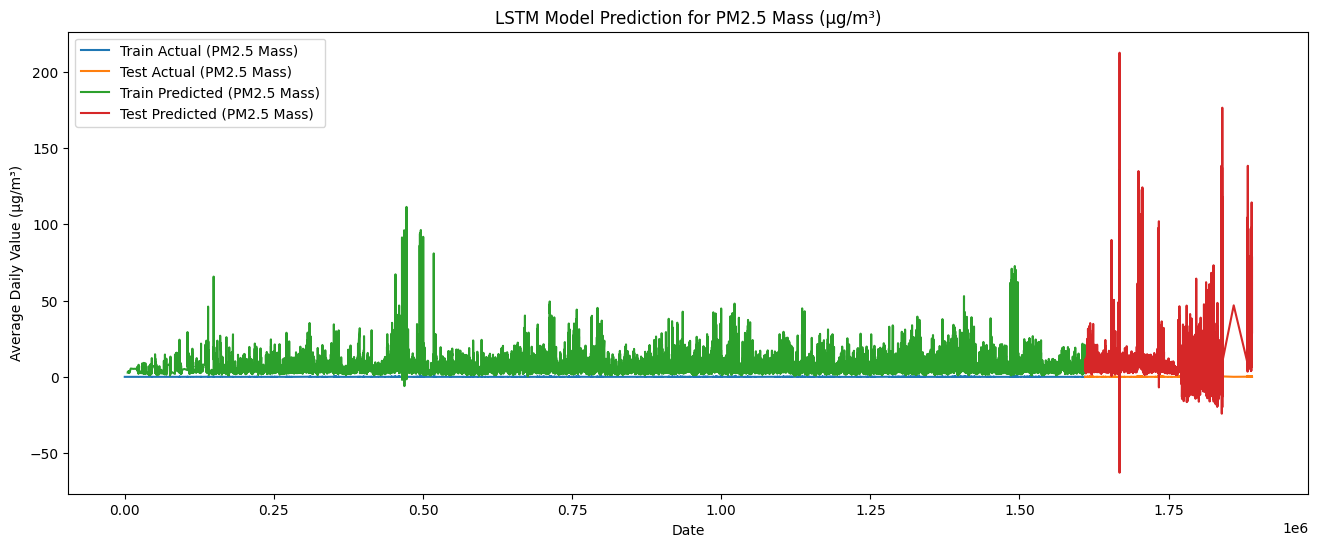

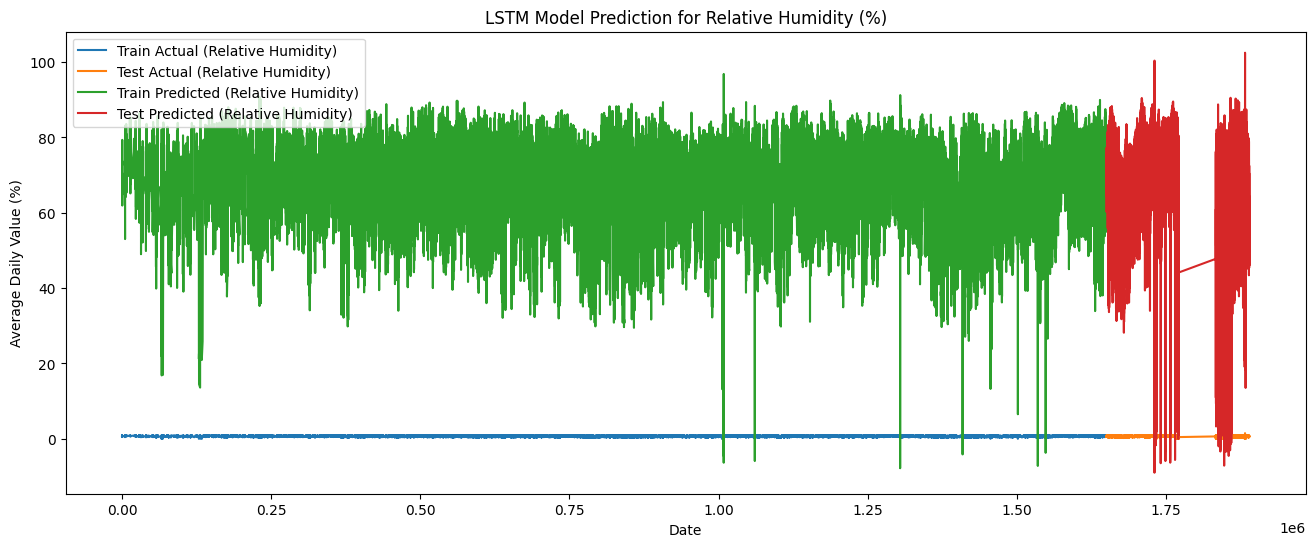

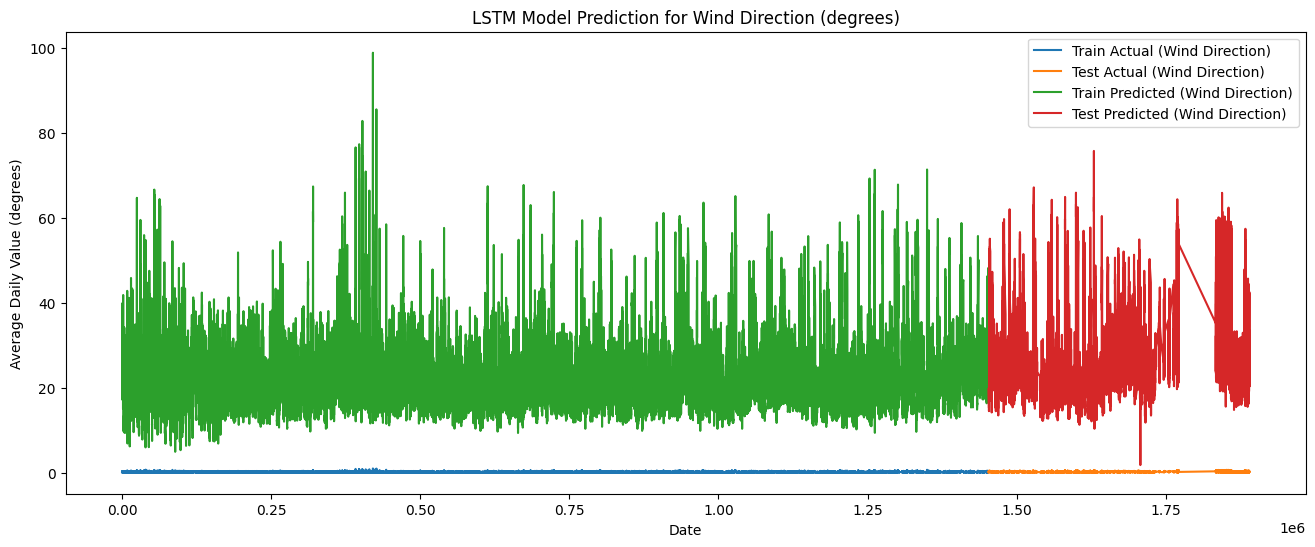

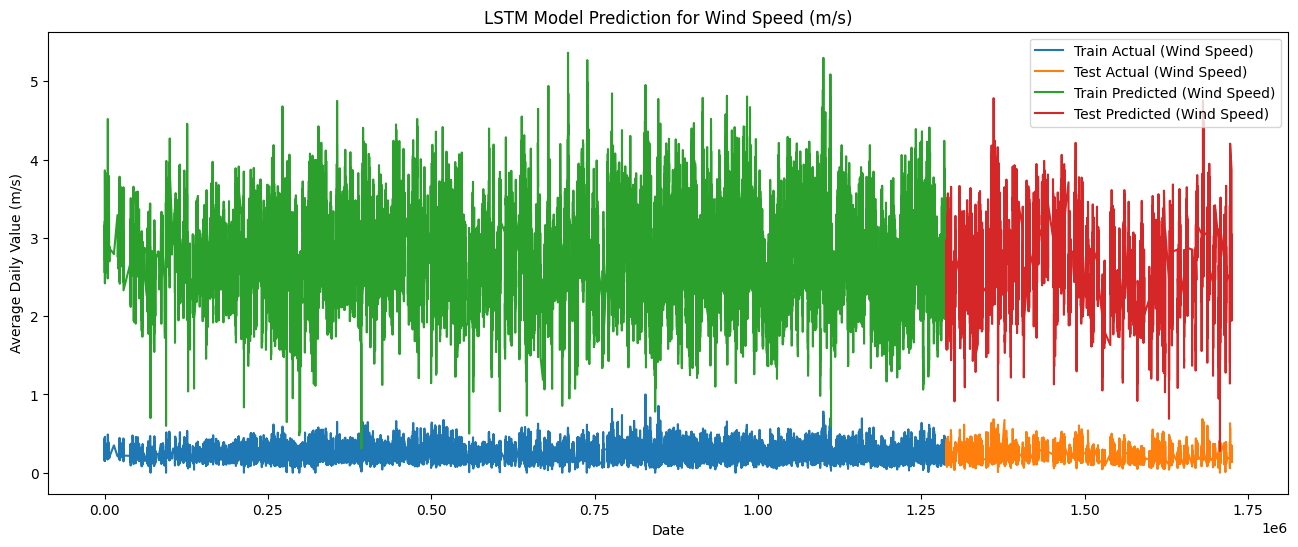

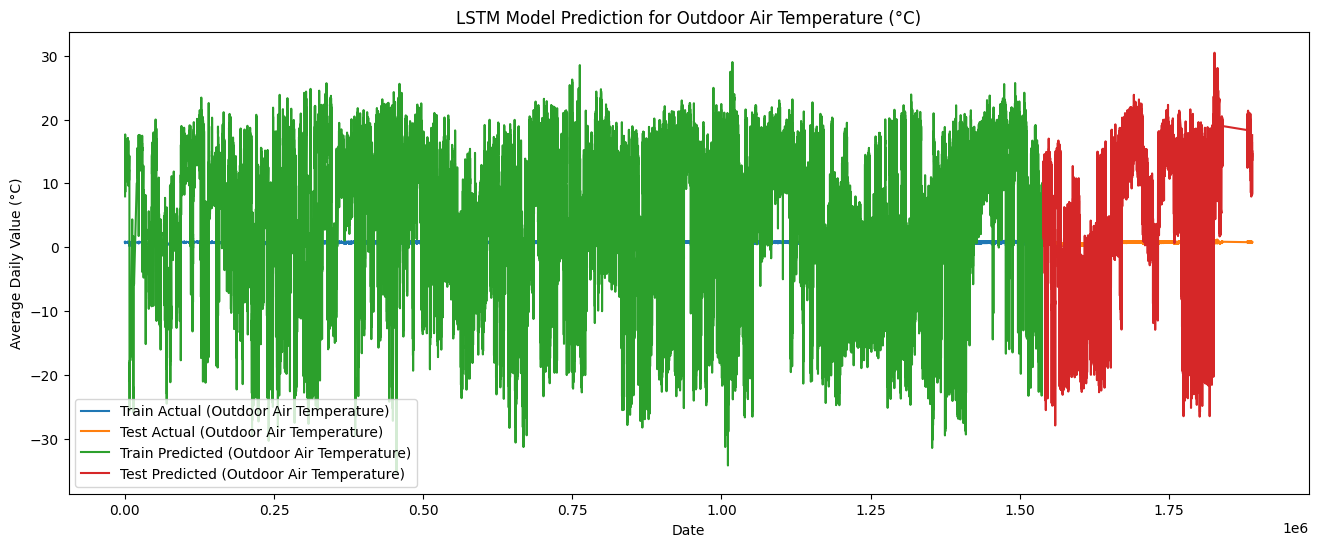

In [8]:
# Plot the results for each parameter
plot_lstm_results(pm25_train, pm25_test, pm25_trainPredict, pm25_testPredict, 'PM2.5 Mass', 'µg/m³')
plot_lstm_results(humidity_train, humidity_test, humidity_trainPredict, humidity_testPredict, 'Relative Humidity', '%')
plot_lstm_results(wind_direction_train, wind_direction_test, wind_direction_trainPredict, wind_direction_testPredict, 'Wind Direction', 'degrees')
plot_lstm_results(wind_speed_train, wind_speed_test, wind_speed_trainPredict, wind_speed_testPredict, 'Wind Speed', 'm/s')
plot_lstm_results(temperature_train, temperature_test, temperature_trainPredict, temperature_testPredict, 'Outdoor Air Temperature', '°C')